完整量化策略开发流程：
1.  数据加载与预处理
2.  使用LightGBM进行时间序列交叉验证和样本外预测
3.  基于模型预测信号进行向量化回测
4.  计算并展示策略的详细性能评估指标

模型选择理由:
- LightGBM: 针对表格数据的高效梯度提升框架，训练速度远快于LSTM，性能优于线性模型。
  非常适合快速迭代和验证策略核心逻辑，解决了原始代码中LSTM训练过慢的问题。

In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style, Back
from sklearn.preprocessing import StandardScaler

# 1. 日志和绘图设置

In [14]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

# 2. 核心函数定义

In [15]:
def train_and_predict_oos(X, y, model, n_splits=5):
    """
    使用时间序列交叉验证来训练模型并生成样本外(Out-of-Sample)预测。
    这是回测的关键，确保预测的无偏性。

    参数:
    - X (pd.DataFrame): 特征数据
    - y (pd.Series): 目标数据
    - model: 一个遵循sklearn API的机器学习模型 (e.g., lgb.LGBMRegressor)
    - n_splits (int): 交叉验证的折数

    返回:
    - pd.Series: 包含所有测试集预测结果的序列，索引与原始数据对齐。
    """
    logging.info(f"🤔开始使用 {n_splits}-fold 时间序列交叉验证进行样本外预测...")
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    oos_predictions = []
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        # --- 数据分割 ---
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        logging.info(f"--- Fold {fold+1}/{n_splits} ---")
        logging.info(f"训练集周期: {X_train.index.min()} -> {X_train.index.max()} (大小: {len(X_train)})")
        logging.info(f"测试集周期: {X_test.index.min()} -> {X_test.index.max()} (大小: {len(X_test)})")

        # --- 模型训练与预测 ---
        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric='l2',
                  callbacks=[lgb.early_stopping(10, verbose=False)])
        
        predictions = model.predict(X_test)
        
        # --- 保存预测结果 ---
        fold_preds = pd.Series(predictions, index=X_test.index)
        oos_predictions.append(fold_preds)

    logging.info("🎉所有Fold的样本外预测完成。")
    return pd.concat(oos_predictions)

In [16]:
def run_vectorized_backtest(prices, signals, initial_capital=100000, commission_rate=0.0005, long_threshold=0.001, short_threshold=-0.001):
    """
    执行向量化回测。

    参数:
    - prices (pd.Series): 'close'价格序列，用于计算收益和净值。
    - signals (pd.Series): 模型的原始预测值序列。
    - initial_capital (float): 初始资金。
    - commission_rate (float): 交易手续费率。
    - long_threshold (float): 做多阈值。
    - short_threshold (float): 做空阈值。

    返回:
    - pd.DataFrame: 包含净值曲线、收益、持仓和交易详情的结果。
    """
    logging.info("🤔🤔开始执行向量化回测...")
    
    '''
    --- 1. 生成交易信号和持仓 ---
    '''
    # 根据阈值将预测信号转换为交易方向: 1 for long, -1 for short, 0 for neutral
    positions = pd.Series(np.select(
        [signals > long_threshold, signals < short_threshold],
        [1, -1],
        default=0
    ), index=signals.index)
    
    # 关键点: 交易决策基于上一期信号，在当期开盘时执行。shift(1)避免未来函数。
    positions = positions.shift(1).fillna(0)
    
    '''
    --- 2. 计算收益 ---
    '''
    # 市场每日/每期收益率
    market_returns = prices.pct_change().fillna(0)
    
    # 策略收益率 = 持仓 * 市场收益率
    strategy_returns = positions * market_returns

    '''
    --- 3. 计算交易成本 ---
    '''
    # 当持仓发生变化时，即为一次交易
    trades = positions.diff().fillna(0)
    transaction_costs = abs(trades) * commission_rate
    
    # 策略净收益率
    strategy_net_returns = strategy_returns - transaction_costs
    
    '''
    --- 4. 计算权益曲线 ---
    '''
    cumulative_returns = (1 + strategy_net_returns).cumprod()
    equity_curve = initial_capital * cumulative_returns
    
    '''
    --- 5. 整合结果 ---
    '''
    backtest_results = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'position': positions,
        'market_returns': market_returns,
        'strategy_returns': strategy_returns,
        'transaction_costs': transaction_costs,
        'strategy_net_returns': strategy_net_returns,
        'equity_curve': equity_curve
    })
    
    logging.info("🎉🎉向量化回测完成。")
    return backtest_results

In [17]:
def evaluate_performance(backtest_results, evaluation_criteria, initial_capital, factor_data=None):
    logging.info("🤔🤔🤔开始评估策略表现...")

    equity_curve = backtest_results['equity_curve']
    net_returns = backtest_results['strategy_net_returns']
    market_returns = backtest_results['market_returns'] # 基准市场收益率
    positions = backtest_results['position']
    trades_raw = positions.diff().fillna(0) # 原始交易信号变化
    
    # --- 识别单笔交易盈亏 ---
    # 辅助列表来存储每次完整交易的净收益
    individual_trade_pnl_list = []
    current_position_type = 0 # 0: 无仓位, 1: 多头, -1: 空头
    entry_time = None

    for i in range(1, len(positions)):
        prev_pos = positions.iloc[i-1]
        curr_pos = positions.iloc[i]
        
        # 如果当前没有仓位，并且上一期有仓位，说明发生了平仓
        if prev_pos != 0 and curr_pos == 0:
            # 计算从 entry_time 到当前时间段的累计净收益率
            entry_idx = backtest_results.index.get_loc(entry_time)
            # 确保切片范围正确，包含平仓那一刻的收益
            trade_net_returns = (1 + backtest_results['strategy_net_returns'].iloc[entry_idx+1 : i+1]).prod() - 1
            individual_trade_pnl_list.append(trade_net_returns)
            current_position_type = 0
            entry_time = None
        
        # 如果当前有仓位，并且上一期没有仓位，说明发生了开仓
        elif prev_pos == 0 and curr_pos != 0:
            current_position_type = curr_pos
            entry_time = backtest_results.index[i]
        
        # 如果仓位方向发生变化 (例如从多头变为空头，或从空头变为多头)
        elif prev_pos != 0 and curr_pos != 0 and prev_pos != curr_pos:
            # 先平掉之前的仓位
            entry_idx = backtest_results.index.get_loc(entry_time)
            trade_net_returns = (1 + backtest_results['strategy_net_returns'].iloc[entry_idx+1 : i+1]).prod() - 1
            individual_trade_pnl_list.append(trade_net_returns)
            
            # 再开新仓
            current_position_type = curr_pos
            entry_time = backtest_results.index[i]
            
    # 处理回测结束时仍有持仓的情况
    if current_position_type != 0 and entry_time is not None: # Added check for entry_time
        entry_idx = backtest_results.index.get_loc(entry_time)
        trade_net_returns = (1 + backtest_results['strategy_net_returns'].iloc[entry_idx+1 :]).prod() - 1
        individual_trade_pnl_list.append(trade_net_returns)

    trade_returns_series = pd.Series(individual_trade_pnl_list)


    '''
    --- 1. 计算核心指标 ---
    '''
    # 年化因子 (基于月度收益率进行年化，一年12个月)
    annualization_factor = 12 

    # 总天数
    total_days = (equity_curve.index[-1] - equity_curve.index[0]).days if len(equity_curve) > 1 else 0
    # 避免除以零
    duration_years = total_days / 365.0 if total_days > 0 else 1 

    # 1. 累积收益率 (Total Return)
    total_return = (equity_curve.iloc[-1] / initial_capital) - 1 if initial_capital != 0 else 0

    # 2. 年化收益率 (Annualized Return)
    # 此处仍使用总收益率进行几何年化，与数据频率无关，是总期间的年化表现
    annualized_return = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (1.0 / duration_years) - 1 if total_days > 0 else 0
    if total_days <= 0:
        annualized_return = 0

    # 计算月度净收益率和月度市场收益率，用于夏普、波动率、索提诺等指标的计算
    monthly_net_returns = (1 + net_returns).resample('M').prod() - 1
    monthly_net_returns = monthly_net_returns.dropna() # 移除没有数据的月份
    
    monthly_market_returns = (1 + market_returns).resample('M').prod() - 1
    monthly_market_returns = monthly_market_returns.dropna() # 移除没有数据的月份

    # 3. 年化波动率 (Annualized Volatility)
    # 基于月度收益率计算标准差，再年化
    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        annualized_volatility = monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        annualized_volatility = 0

    # 4. 最大回撤 (MDD) 及日期
    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = abs(drawdown.min())

    # 找到最大回撤的起始和结束日期
    temp_drawdown = drawdown.copy()
    end_date_idx = temp_drawdown.idxmin() # 最大回撤的最低点日期
    
    # 找到最大回撤最低点之前的最高点日期
    if end_date_idx is not None:
        peak_idx = equity_curve.loc[:end_date_idx].idxmax()
        max_drawdown_start_date = peak_idx
        max_drawdown_end_date = end_date_idx
    else:
        max_drawdown_start_date = None
        max_drawdown_end_date = None


    # 5. 夏普比率 (Sharpe Ratio)
    # 基于月度收益率计算均值和标准差，再年化
    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        sharpe_ratio = monthly_net_returns.mean() / monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        sharpe_ratio = 0

    # 6. 卡玛比率 (Calmar Ratio)
    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else 0

    # 7. 交易统计 (使用更准确的 individual_trade_pnl_list)
    winning_trades_pnl = trade_returns_series[trade_returns_series > 0]
    losing_trades_pnl = trade_returns_series[trade_returns_series <= 0]
    
    total_trades = len(trade_returns_series)
    num_winning_trades = len(winning_trades_pnl)
    num_losing_trades = len(losing_trades_pnl)

    win_rate = num_winning_trades / total_trades if total_trades > 0 else 0
    
    total_profit_amount_trades = winning_trades_pnl.sum()
    total_loss_amount_trades = abs(losing_trades_pnl.sum())
    
    profit_loss_ratio = total_profit_amount_trades / total_loss_amount_trades if total_loss_amount_trades > 0 else np.inf
    
    # 8. 期望收益 (Expectancy)
    expectancy = (win_rate * profit_loss_ratio) - (1 - win_rate) if win_rate > 0 and profit_loss_ratio != np.inf else -1

    # 9. 每周开仓频率
    open_positions = trades_raw[(trades_raw == 1) | (trades_raw == -1)]
    num_open_trades = len(open_positions)
    
    total_weeks = len(pd.date_range(start=equity_curve.index[0],
                                     end=equity_curve.index[-1],
                                     freq=Week()))
    weekly_trade_frequency = num_open_trades / total_weeks if total_weeks > 0 else 0

    # 10. 索提诺比率 (Sortino Ratio)
    # 基于月度收益率计算下行波动率，再年化
    downside_monthly_returns = monthly_net_returns[monthly_net_returns < 0]
    if not downside_monthly_returns.empty and downside_monthly_returns.std() != 0:
        downside_std = downside_monthly_returns.std()
        sortino_ratio = monthly_net_returns.mean() / downside_std * np.sqrt(annualization_factor)
    else:
        sortino_ratio = 0

    # 11. 平均盈利和平均亏损
    average_win = winning_trades_pnl.mean() if num_winning_trades > 0 else 0
    average_loss = losing_trades_pnl.mean() if num_losing_trades > 0 else 0
    
    # 12. 总盈亏金额 (Total PnL)
    total_pnl_amount = equity_curve.iloc[-1] - initial_capital

    # 13. 逐年收益率 (Annual Returns)
    # 计算每个自然年的收益率
    annual_returns = (1 + net_returns).resample('Y').prod() - 1
    annual_returns.index = annual_returns.index.year # 将索引改为年份

    # --- 超额指标计算 ---
    # 基准权益曲线 (Buy & Hold)
    benchmark_equity = initial_capital * (backtest_results['close'] / backtest_results['close'].iloc[0])
    
    # 超额收益率 (Excess Return): (1+策略月度收益率)/(1+基准月度收益率) - 1
    # 基于月度收益率计算超额收益
    if not monthly_net_returns.empty and not monthly_market_returns.empty:
        excess_monthly_returns_series = (1 + monthly_net_returns) / (1 + monthly_market_returns) - 1
        excess_monthly_returns_series = excess_monthly_returns_series.dropna()
    else:
        excess_monthly_returns_series = pd.Series([])

    # 超额权益曲线 (Excess Equity Curve)
    # 以初始资金为基准，计算超额收益的累积乘积
    if not excess_monthly_returns_series.empty:
        excess_equity_curve = initial_capital * (1 + excess_monthly_returns_series).cumprod()
    else:
        # 如果没有超额收益数据，则超额权益曲线为初始资金
        excess_equity_curve = pd.Series([initial_capital], index=[equity_curve.index[0]])

    # 年化超额收益率 (Annualized Excess Return)
    # 基于超额权益曲线进行几何年化
    if not excess_equity_curve.empty and len(excess_equity_curve) > 1 and total_days > 0:
        annualized_excess_return = (excess_equity_curve.iloc[-1] / excess_equity_curve.iloc[0]) ** (1.0 / duration_years) - 1
    else:
        annualized_excess_return = 0

    # 超额波动率 (Excess Volatility)
    # 基于月度超额收益率计算波动率，再年化
    if not excess_monthly_returns_series.empty and excess_monthly_returns_series.std() != 0:
        excess_volatility = excess_monthly_returns_series.std() * np.sqrt(annualization_factor)
    else:
        excess_volatility = 0

    # 超额最大回撤 (Excess Maximum Drawdown)
    # 确保 excess_max_drawdown 始终被定义
    excess_max_drawdown = 0 # Initialize to 0
    if not excess_equity_curve.empty:
        excess_running_max = excess_equity_curve.cummax()
        excess_drawdown = (excess_equity_curve - excess_running_max) / excess_running_max
        excess_max_drawdown = abs(excess_drawdown.min())


    # 超额夏普比率 (Excess Sharpe Ratio)
    # 基于月度超额收益率计算夏普比率
    if not excess_monthly_returns_series.empty and excess_monthly_returns_series.std() != 0:
        excess_sharpe_ratio = excess_monthly_returns_series.mean() / excess_monthly_returns_series.std() * np.sqrt(annualization_factor)
    else:
        excess_sharpe_ratio = 0


    # 换手率 (Turnover)
    # 换手率 = 总交易金额 / 平均资产管理规模 (AUM)
    # 交易金额 = 每次仓位变化量 * 交易时的价格
    # 注意：positions 已经 shift(1) 了，所以 trades_raw 是在 t 时刻根据 t-1 的信号做的交易
    # 交易发生的价格应是 backtest_results['close'] 在 trades_raw 非零的那些点
    value_traded_per_period = abs(trades_raw) * backtest_results['close']
    total_value_traded = value_traded_per_period.sum()

    average_aum = equity_curve.mean() # 平均资产管理规模

    # 年化换手率
    # total_value_traded / average_aum 得到的是回测期间的总换手率
    # 再除以回测的年数，得到年化换手率
    annualized_turnover = (total_value_traded / average_aum) / duration_years if average_aum > 0 and duration_years > 0 else 0
    
    
    '''
    --- 2. 打印评估报告 ---
    '''
    print("\n" + "="*80)
    print(Fore.CYAN + " " * 30 + "策略性能评估报告" + " " * 30 + Style.RESET_ALL)
    print("="*80)
    
    # 辅助函数，用于格式化输出
    def format_check(name, value, req_value, req_prefix, comp_func):
        status = "✅ 达标" if comp_func(value, req_value) else "❌ 未达标"
        req_str = f"{req_prefix} {req_value}"
        color = Fore.GREEN if comp_func(value, req_value) else Fore.RED
        return [name, f"{value:.4f}", req_str, color + status + Style.RESET_ALL]

    # 收益指标
    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " 收益指标 " + "="*30 + Style.RESET_ALL)
    sharpe_req = evaluation_criteria['sharpe_ratio']
    calmar_req = evaluation_criteria['calmar_ratio']
    expectancy_req = evaluation_criteria['expectancy']
    
    sharpe_ok = sharpe_ratio > sharpe_req
    calmar_ok = calmar_ratio > calmar_req
    expectancy_ok = expectancy > expectancy_req
    
    profit_plan1_ok = sharpe_ok and calmar_ok
    profit_plan2_ok = expectancy_ok
    profit_ok = profit_plan1_ok or profit_plan2_ok
    
    # 使用tabulate创建表格
    headers = ["指标名称", "计算结果", "要求", "状态"]
    profit_table = [
        format_check("夏普比率 (Sharpe)", sharpe_ratio, sharpe_req, ">", lambda v, r: v > r),
        format_check("卡玛比率 (Calmar)", calmar_ratio, calmar_req, ">", lambda v, r: v > r),
        format_check("期望收益 (Expectancy)", expectancy, expectancy_req, ">", lambda v, r: v > r)
    ]
    
    print(tabulate(profit_table, headers=headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # 添加方案状态
    plan_table = [
        ["方案一 (夏普 & 卡玛)", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_plan1_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["方案二 (期望收益)", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_plan2_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合收益指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print("\n" + tabulate(plan_table, headers=["策略方案", "状态"], tablefmt="grid", stralign="center"))
    
    # 持仓统计
    long_positions_count = len(positions[positions == 1])
    short_positions_count = len(positions[positions == -1])
    total_positions_count = long_positions_count + short_positions_count
    
    position_table = [
        ["多头持仓占比", f"{long_positions_count/total_positions_count:.2%}" if total_positions_count > 0 else "0.00%"],
        ["空头持仓占比", f"{short_positions_count/total_positions_count:.2%}" if total_positions_count > 0 else "0.00%"]
    ]
    print("\n" + tabulate(position_table, headers=["持仓统计", ""], tablefmt="grid", stralign="center"))

    # 风控与效率指标
    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " 风控与效率指标 " + "="*30 + Style.RESET_ALL)
    mdd_req = evaluation_criteria['max_drawdown']
    freq_req = evaluation_criteria['weekly_frequency']
    
    mdd_ok = max_drawdown < mdd_req
    freq_ok = weekly_trade_frequency > freq_req
    
    risk_table = [
        format_check("最大回撤 (MDD)", max_drawdown, mdd_req, "<", lambda v, r: v < r),
        format_check("每周开仓频率", weekly_trade_frequency, freq_req, ">", lambda v, r: v > r)
    ]
    
    print(tabulate(risk_table, headers=headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # 添加风控状态
    risk_status_table = [
        ["综合风控指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if mdd_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合效率指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if freq_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print("\n" + tabulate(risk_status_table, headers=["指标", "状态"], tablefmt="grid", stralign="center"))

    # --- 更多常见指标展示 ---
    print("\n" + Fore.GREEN + Style.BRIGHT + "="*30 + " 详细指标 " + "="*30 + Style.RESET_ALL)
    
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["总收益 (Total Return)", f"{total_return:.4f}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.4f}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.4f}"],
        ["索提诺比率 (Sortino Ratio)", f"{sortino_ratio:.4f}"],
        ["总盈亏 (Total PnL)", f"{total_pnl_amount:,.2f}"],
        ["总交易笔数 (Total Trades)", f"{total_trades}"],
        ["盈利交易笔数 (Winning Trades)", f"{num_winning_trades}"],
        ["亏损交易笔数 (Losing Trades)", f"{num_losing_trades}"],
        ["胜率 (Win Rate)", f"{win_rate:.4f}"],
        ["盈亏比 (Profit Factor)", f"{profit_loss_ratio:.4f}"],
        ["平均盈利 (Average Win)", f"{average_win:.4f}"],
        ["平均亏损 (Average Loss)", f"{average_loss:.4f}"],
        ["年化换手率 (Annualized Turnover)", f"{annualized_turnover:.4f}"],
        ["最大回撤起始日期", str(max_drawdown_start_date)],
        ["最大回撤结束日期", str(max_drawdown_end_date)]
    ]
    
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))

    # 逐年收益率
    print("\n" + Fore.MAGENTA + Style.BRIGHT + "="*30 + " 逐年收益率 " + "="*30 + Style.RESET_ALL)
    annual_returns_df = annual_returns.reset_index()
    annual_returns_df.columns = ["年份", "收益率"]
    annual_returns_df["收益率"] = annual_returns_df["收益率"].apply(lambda x: f"{x:.4f}")
    print(tabulate(annual_returns_df, headers="keys", tablefmt="grid", stralign="center", showindex=False))

    # 超额指标
    print("\n" + Fore.CYAN + Style.BRIGHT + "="*30 + " 超额指标 " + "="*30 + Style.RESET_ALL)
    excess_table = [
        ["年化超额收益率", f"{annualized_excess_return:.4f}"],
        ["超额波动率", f"{excess_volatility:.4f}"],
        ["超额最大回撤", f"{excess_max_drawdown:.4f}"],
        ["超额夏普比率", f"{excess_sharpe_ratio:.4f}"]
    ]
    print(tabulate(excess_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))


    '''
    --- 3. 绘制权益曲线图 & 基准对比 & 因子散点图 ---
    '''
    # 创建一个包含两个子图的图表
    # 保持宽度为 15，总高度增加，并设置 ax1 和 ax2 的高度比例
    # 权益曲线图高度保持在 8，因子图高度增加到 20，总高度为 28
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 28), sharex=True, gridspec_kw={'height_ratios': [8, 20]})
    
    # 绘制策略权益曲线
    equity_curve.plot(label='Strategy Equity', lw=2, color='royalblue', ax=ax1)
    
    # 绘制 "买入并持有" 基准曲线
    benchmark_equity.plot(label='Buy & Hold Benchmark', lw=2, linestyle='--', color='darkorange', ax=ax1)

    # 绘制超额权益曲线
    if not excess_equity_curve.empty:
        excess_equity_curve.plot(label='Excess Equity (vs. Benchmark)', lw=2, linestyle=':', color='forestgreen', ax=ax1)

    ax1.set_title('Strategy, Benchmark & Excess Equity Curves', fontsize=16)
    ax1.set_ylabel('Equity', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    # 显式地显示第一张图的X轴标签
    ax1.tick_params(labelbottom=True) 
    
    # 绘制因子散点图
    if factor_data is not None and not factor_data.empty:
        # 对因子数据进行标准化，以便在同一图上比较不同量纲的因子
        scaler = StandardScaler()
        scaled_factor_data = pd.DataFrame(scaler.fit_transform(factor_data), 
                                          columns=factor_data.columns, 
                                          index=factor_data.index)

        # 定义极端值的阈值（例如，超过3个标准差）
        EXTREME_THRESHOLD = 3 

        # 用于收集所有极端值信息
        all_extreme_values = []

        # 将所有因子数据堆叠起来，方便统一处理正常值和极端值
        all_scaled_values = scaled_factor_data.stack().reset_index()
        all_scaled_values.columns = ['Timestamp', 'Factor', 'Scaled Value']
        
        # 根据阈值区分正常值和极端值
        normal_points = all_scaled_values[abs(all_scaled_values['Scaled Value']) <= EXTREME_THRESHOLD]
        extreme_points = all_scaled_values[abs(all_scaled_values['Scaled Value']) > EXTREME_THRESHOLD]

        # 绘制正常值点 (统一颜色)
        normal_scatter = ax2.scatter(normal_points['Timestamp'], normal_points['Scaled Value'], 
                                     s=1, alpha=0.6, color='steelblue', label='Normal Value')
        
        # 绘制极端值点 (红色 'X' 标记，略大)
        if not extreme_points.empty:
            extreme_scatter = ax2.scatter(extreme_points['Timestamp'], extreme_points['Scaled Value'], 
                                          s=2, color='red', linewidth=0.8, zorder=5, 
                                          label=f'Extreme Value (> $\\pm${EXTREME_THRESHOLD} StdDev)')
            
            # 收集极端值信息
            for _, row in extreme_points.iterrows():
                all_extreme_values.append({
                    'Timestamp': row['Timestamp'],
                    'Factor': row['Factor'],
                    'Scaled Value': row['Scaled Value'],
                    'Original Value': factor_data.loc[row['Timestamp'], row['Factor']]
                })
        
        # 构建图例句柄和标签
        handles = [normal_scatter]
        labels = ['Normal Value']
        if 'extreme_scatter' in locals(): # 只有当有极端值被绘制时才添加其图例
            handles.append(extreme_scatter)
            labels.append(f'Extreme Value (> $\\pm${EXTREME_THRESHOLD} StdDev)')

        ax2.set_title('Scaled Factor Values Over Time (Normal vs. Extreme)', fontsize=14) # 更新标题
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Scaled Factor Value', fontsize=12)
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend(handles=handles, labels=labels, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1)) 
        plt.subplots_adjust(right=0.85) # 调整子图参数以腾出图例空间
    else:
        logging.warning("未提供因子数据或因子数据为空，无法绘制因子散点图。")
        all_extreme_values = [] # 确保即使没有因子数据也定义了此变量

    plt.tight_layout()
    plt.show()

    '''
    --- 4. 极端因子值文字分析 (统计汇总) ---
    '''
    print("\n" + "="*80)
    print(Fore.YELLOW + Style.BRIGHT + " " * 25 + "极端因子值统计分析" + " " * 25 + Style.RESET_ALL)
    print("="*80)

    if all_extreme_values:
        extreme_df = pd.DataFrame(all_extreme_values)
        extreme_df['Timestamp'] = pd.to_datetime(extreme_df['Timestamp']) # 确保时间戳是datetime类型

        # 1. 极端值总数
        total_extreme_occurrences = len(extreme_df)
        print(f"检测到的极端因子值总数: {Fore.CYAN}{total_extreme_occurrences}{Style.RESET_ALL} 个 (标准化值绝对值 > {EXTREME_THRESHOLD})")

        # 2. 每个因子出现极端值的次数
        print("\n每个因子出现极端值的次数:")
        factor_extreme_counts = extreme_df['Factor'].value_counts().reset_index()
        factor_extreme_counts.columns = ['因子名称', '出现次数']
        print(tabulate(factor_extreme_counts, headers="keys", tablefmt="grid", stralign="center", showindex=False))

        # 3. 最正和最负的极端值 (例如，前10个)
        num_top_extremes = 10
        print(f"\n最正的 {num_top_extremes} 个极端因子值:")
        top_positive_extremes = extreme_df.nlargest(num_top_extremes, 'Scaled Value')
        print(tabulate(top_positive_extremes[['Timestamp', 'Factor', 'Scaled Value', 'Original Value']], 
                       headers="keys", tablefmt="grid", stralign="center", showindex=False))

        print(f"\n最负的 {num_top_extremes} 个极端因子值:")
        top_negative_extremes = extreme_df.nsmallest(num_top_extremes, 'Scaled Value')
        print(tabulate(top_negative_extremes[['Timestamp', 'Factor', 'Scaled Value', 'Original Value']], 
                       headers="keys", tablefmt="grid", stralign="center", showindex=False))
        
        print(Fore.BLUE + "\n分析建议: 上述统计数据有助于识别哪些因子更容易出现极端情况，以及这些极端情况的程度。".ljust(76) + Style.RESET_ALL)

    else:
        print(Fore.GREEN + "在回测期间未发现明显超出 $\\pm3$ 标准差的极端因子值。这表明因子数据在标准化后相对稳定。".ljust(76) + Style.RESET_ALL)
    
    print("\n" + "="*80)

    logging.info("🎊🎊🎊策略评估完成🎊🎊🎊")

# 3. 主程序执行

2025-07-22 10:45:17,490 - INFO - 正在从 /public/data/factor_data/BTCUSDT_15m_2020_2025_factor_data.pkl 加载数据...
/tmp/ipykernel_88160/2238288424.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['target'] = data['close'].shift(-10) / data['close'] - 1
2025-07-22 10:45:17,534 - INFO - 动态选择了 136 个因子。
2025-07-22 10:45:17,764 - INFO - 数据准备完成。工作数据区间大小: 119767
2025-07-22 10:45:17,765 - INFO - 🤔开始使用 5-fold 时间序列交叉验证进行样本外预测...
2025-07-22 10:45:17,776 - INFO - --- Fold 1/5 ---
2025-07-22 10:45:17,777 - INFO - 训练集周期: 2021-10-01 00:00:00 -> 2022-04-26 22:15:00 (大小: 19962)
2025-07-22 10:45:17,778 - INFO - 测试集周期: 2022-04-26 22:30:00 -> 2022-11-21 06:45:00 (大小: 19961)
2025-07-22 10:45:17,963 - INFO - --- Fold 2/5 ---
2025-07-22 10:45:17,964 - INFO - 训练集周期: 2021-10-01 0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24835
[LightGBM] [Info] Number of data points in the train set: 19962, number of used features: 133
[LightGBM] [Info] Start training from score -0.000011


2025-07-22 10:45:18,256 - INFO - --- Fold 3/5 ---
2025-07-22 10:45:18,257 - INFO - 训练集周期: 2021-10-01 00:00:00 -> 2023-06-17 05:00:00 (大小: 59884)
2025-07-22 10:45:18,258 - INFO - 测试集周期: 2023-06-17 05:15:00 -> 2024-01-11 03:15:00 (大小: 19961)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24843
[LightGBM] [Info] Number of data points in the train set: 39923, number of used features: 135
[LightGBM] [Info] Start training from score -0.000191


2025-07-22 10:45:18,722 - INFO - --- Fold 4/5 ---
2025-07-22 10:45:18,724 - INFO - 训练集周期: 2021-10-01 00:00:00 -> 2024-01-11 03:15:00 (大小: 79845)
2025-07-22 10:45:18,724 - INFO - 测试集周期: 2024-01-11 03:30:00 -> 2024-08-06 01:30:00 (大小: 19961)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24843
[LightGBM] [Info] Number of data points in the train set: 59884, number of used features: 135
[LightGBM] [Info] Start training from score -0.000033


2025-07-22 10:45:19,221 - INFO - --- Fold 5/5 ---
2025-07-22 10:45:19,222 - INFO - 训练集周期: 2021-10-01 00:00:00 -> 2024-08-06 01:30:00 (大小: 99806)
2025-07-22 10:45:19,223 - INFO - 测试集周期: 2024-08-06 01:45:00 -> 2025-03-01 23:45:00 (大小: 19961)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24845
[LightGBM] [Info] Number of data points in the train set: 79845, number of used features: 135
[LightGBM] [Info] Start training from score 0.000050


2025-07-22 10:45:19,768 - INFO - 🎉所有Fold的样本外预测完成。
2025-07-22 10:45:19,839 - INFO - 🤔🤔开始执行向量化回测...
2025-07-22 10:45:19,848 - INFO - 🎉🎉向量化回测完成。
2025-07-22 10:45:19,887 - INFO - 🤔🤔🤔开始评估策略表现...


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24844
[LightGBM] [Info] Number of data points in the train set: 99806, number of used features: 135
[LightGBM] [Info] Start training from score 0.000067

                              策略性能评估报告                              

============================== 收益指标 ==============================
+-----------------------+------------+--------+-----------+
|       指标名称        |  计算结果  |  要求  |   状态    |
+=======================+============+========+===========+
|   夏普比率 (Sharpe)   |  -0.4403   | > 2.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
|   卡玛比率 (Calmar)   |   -0.224   | > 5.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
| 期望收益 (Expectancy) |   -0.483   | > 0.25 | ❌ 未达标 |
+-----------------------+------------+--------+-----------+

+------------

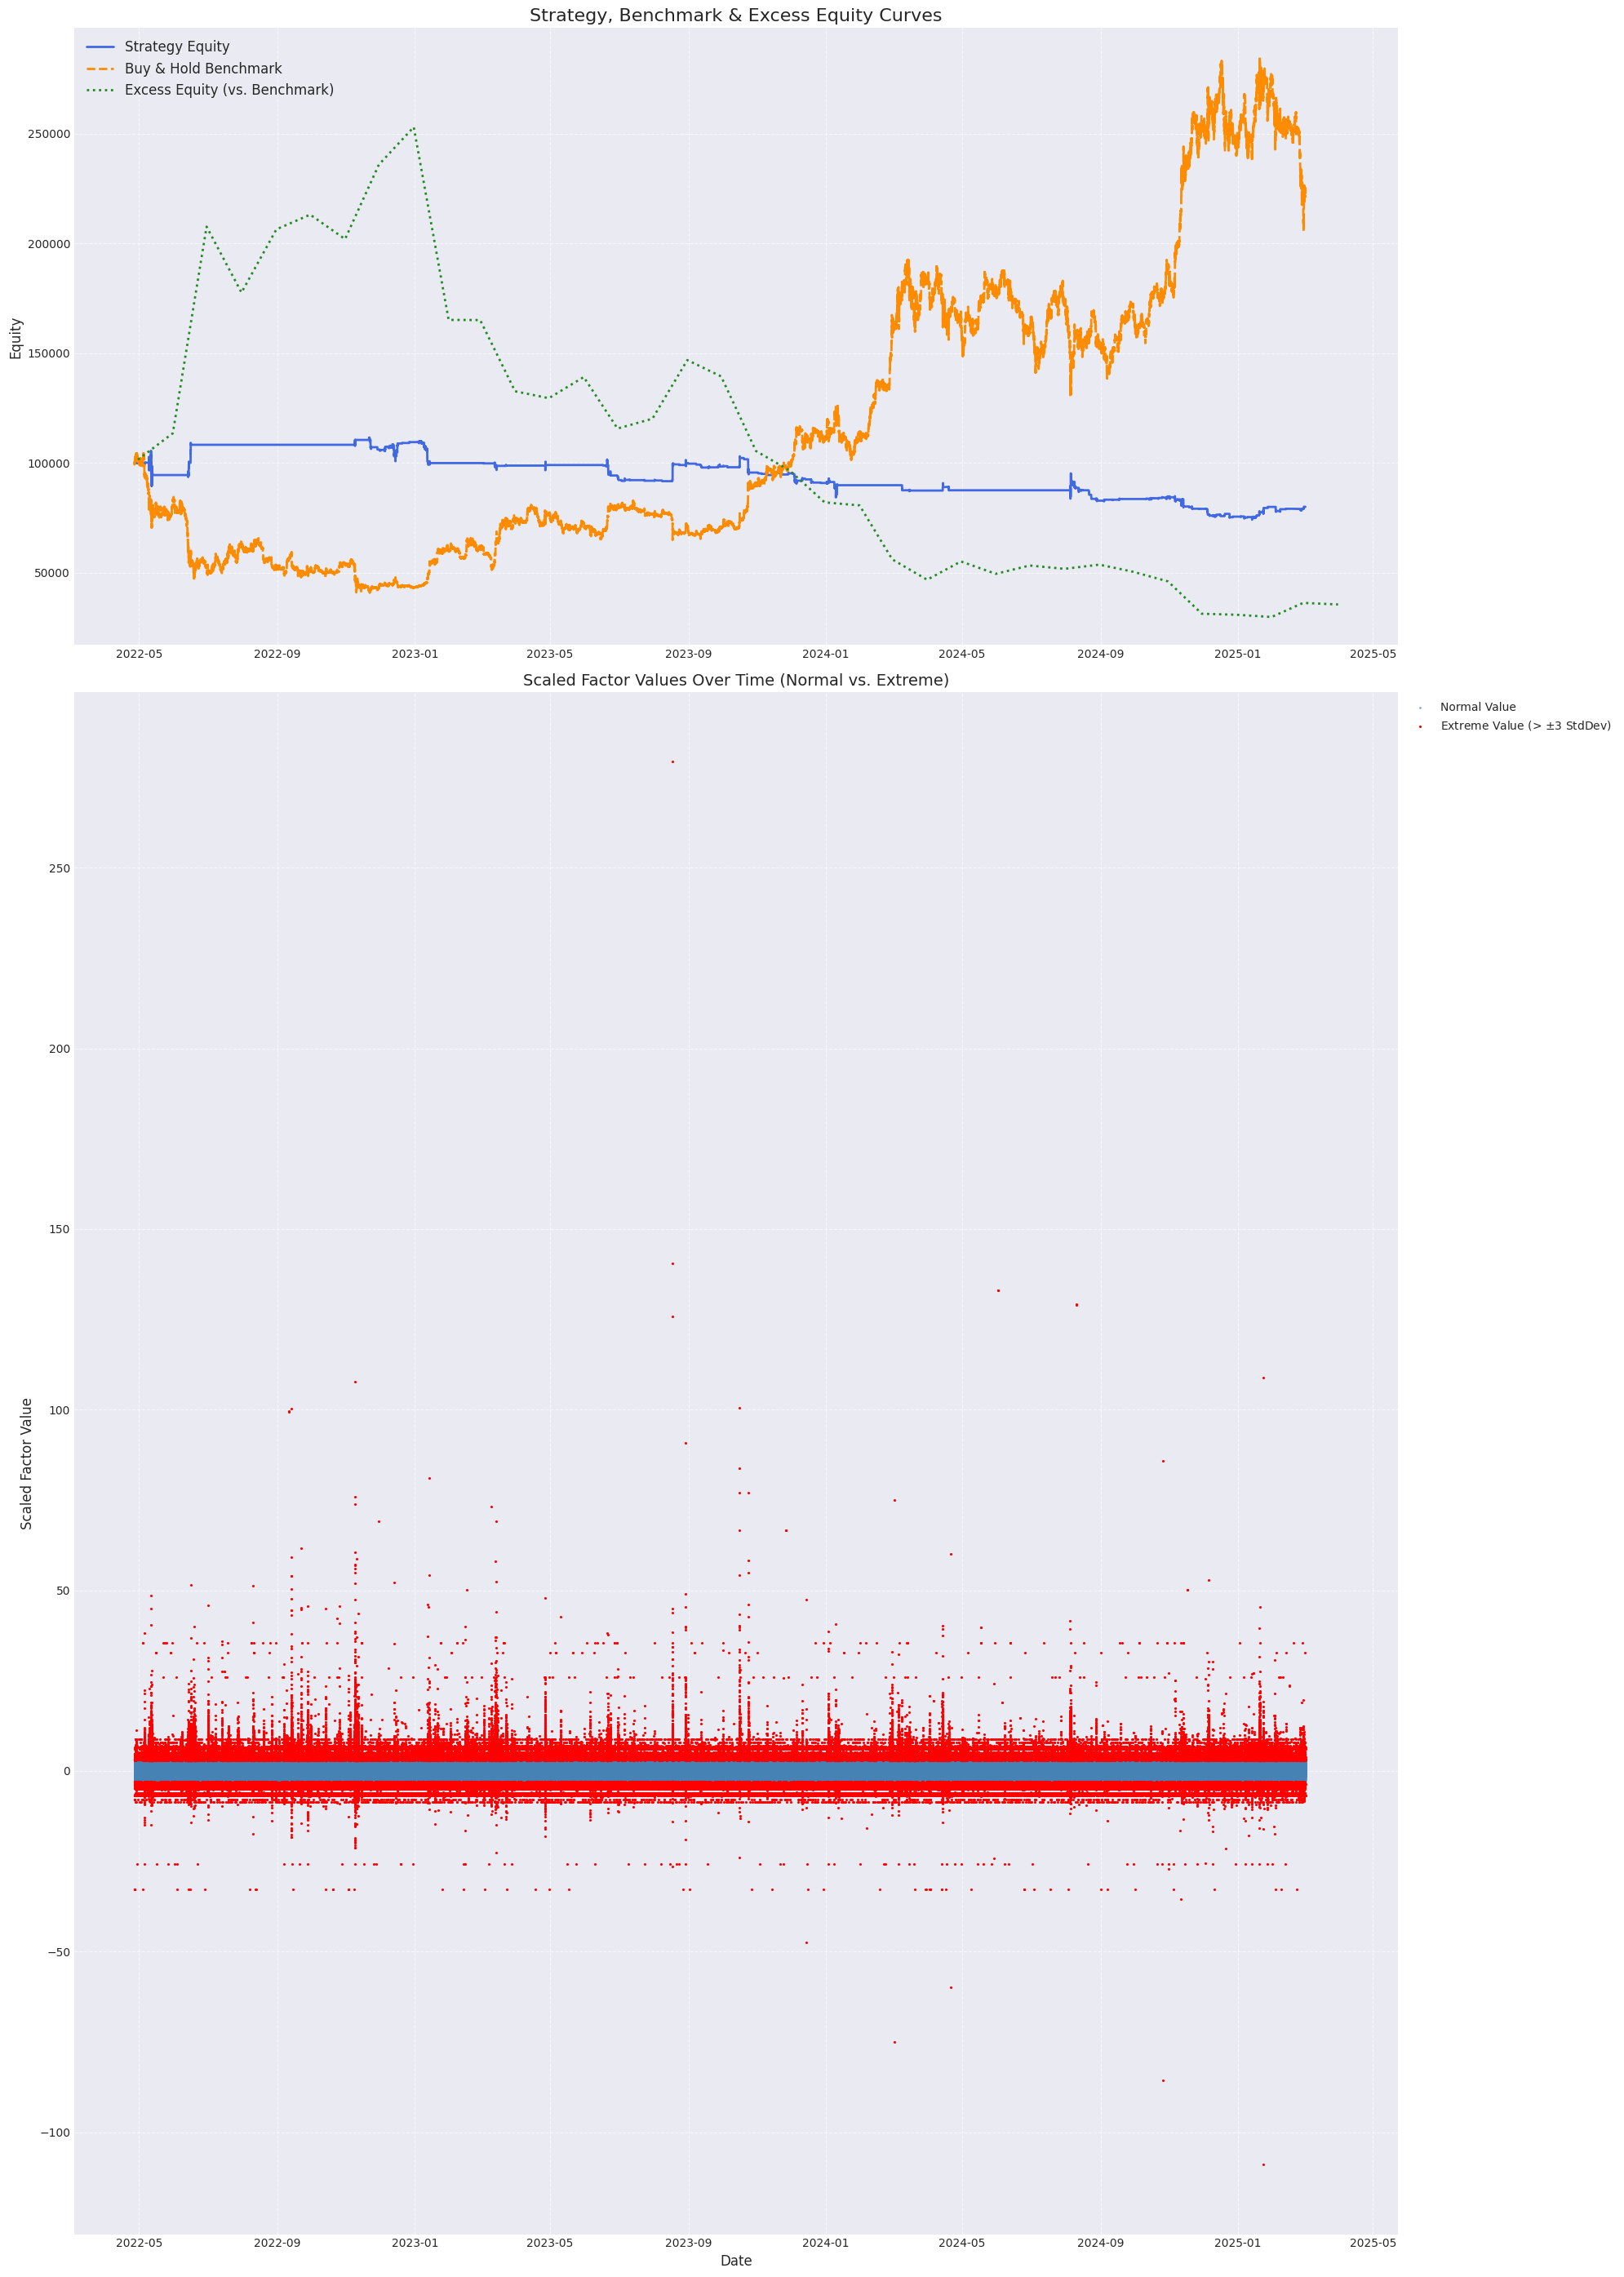


                         极端因子值统计分析                         


2025-07-22 10:45:41,864 - INFO - 🎊🎊🎊策略评估完成🎊🎊🎊


检测到的极端因子值总数: 252956 个 (标准化值绝对值 > 3)

每个因子出现极端值的次数:
+-----------------------------------+------------+
|             因子名称              |   出现次数 |
+===================================+============+
|      ret_ma_arrangement_sig       |       9715 |
+-----------------------------------+------------+
|        ret_macd_sig_price         |       7965 |
+-----------------------------------+------------+
|        ret_skdj_sig_price         |       7095 |
+-----------------------------------+------------+
|          ret_wma_signals          |       6994 |
+-----------------------------------+------------+
|  ret_ma20_ma120_cross_sig_price   |       6174 |
+-----------------------------------+------------+
|          ret_ena_signals          |       6145 |
+-----------------------------------+------------+
|         ret_rsi_boll_sig          |       5134 |
+-----------------------------------+------------+
|       ret_hv_ratio_signals        |       4932 |
+-----------------------------------+--

In [ ]:
if __name__ == '__main__':
    # --- 参数配置 ---
    # 文件路径 (请根据您的服务器环境修改)
    FACTOR_DATA_PATH = '/public/data/factor_data'
    FILE_NAME = 'BTCUSDT_15m_2020_2025_factor_data.pkl'
    
    # 数据时间范围
    BEGIN_DATE = '2021-01-01'
    END_DATE = '2025-03-01'
    
    # 回测参数
    LONG_THRESHOLD = 0.0005      # 预测收益率 > 0.05% 则做多
    SHORT_THRESHOLD = -0.0005    # 预测收益率 < -0.05% 则做空
    COMMISSION_RATE = 0.0002     # 按照🪙Binance taker fee: 0.02%
    INITIAL_CAPITAL = 100000     # 初始资金
    
    # 模型评估标准
    EVALUATION_CRITERIA = {
        'sharpe_ratio': 2.0,
        'calmar_ratio': 5.0,
        'expectancy': 0.25,
        'max_drawdown': 0.20, # 20%
        'weekly_frequency': 5
    }

    # --- 步骤 1: 数据加载和准备 ---
    file_path = os.path.join(FACTOR_DATA_PATH, FILE_NAME)
    logging.info(f"正在从 {file_path} 加载数据...")
    
    data = pd.read_pickle(file_path)

    # 定义预测目标: 未来10个15分钟bar后的收益率
    data['target'] = data['close'].shift(-10) / data['close'] - 1
    
    # 动态选择所有因子
    # 首先定义已知的非因子列 (OHLCV + target)
    non_factor_columns = ['open', 'high', 'low', 'close', 'volume', 'target']
    # 从数据的所有列中排除非因子列，剩下的就是因子列
    all_columns = data.columns.tolist()
    SELECTED_FACTORS = [col for col in all_columns if col not in non_factor_columns]
    logging.info(f"动态选择了 {len(SELECTED_FACTORS)} 个因子。")
    
    # 选取工作数据区间并去除NaN值
    columns_to_keep = SELECTED_FACTORS + ['target', 'close']
    working_data = data[columns_to_keep][BEGIN_DATE:END_DATE].dropna()
    
    X_data = working_data[SELECTED_FACTORS]
    y_data = working_data['target']
    
    logging.info(f"数据准备完成。工作数据区间大小: {len(working_data)}")
    
    # --- 步骤 2: 模型训练和样本外预测 ---
    lgbm = lgb.LGBMRegressor(random_state=42, n_estimators=200, learning_rate=0.05, num_leaves=31)
    
    # 获取样本外预测结果
    oos_preds = train_and_predict_oos(X_data, y_data, lgbm, n_splits=5)
    
    # 将预测结果与回测所需的价格数据对齐
    backtest_data = working_data.loc[oos_preds.index].copy()
    backtest_data['prediction'] = oos_preds
    
    # --- 3. 执行回测 ---
    backtest_results = run_vectorized_backtest(
        prices=backtest_data['close'],
        signals=backtest_data['prediction'],
        initial_capital=INITIAL_CAPITAL,
        commission_rate=COMMISSION_RATE,
        long_threshold=LONG_THRESHOLD,
        short_threshold=SHORT_THRESHOLD
    )
    
    # --- 4. 性能评估 ---
    # 传入 INITIAL_CAPITAL 用于基准计算
    # 传入 X_data (即因子数据) 用于因子可视化
    evaluate_performance(backtest_results, EVALUATION_CRITERIA, INITIAL_CAPITAL, factor_data=X_data.loc[backtest_results.index])